In [45]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from verstack.stratified_continuous_split import scsplit # pip install verstack

import sys
import pickle
from pickle import dump
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import seaborn as sns
import joblib
from sklearn.utils import shuffle

import time

In [60]:
def get_data(training=-1,testing=-1,all_dataset=False):
    pickel_in = open("data/train_data_preprocessed.csv", "rb")
    train_data_prepro = pickle.load(pickel_in)
    
    pickel_in = open("data/evaluation_preprocessed.csv", "rb")
    eval_data_prepro = pickle.load(pickel_in)
#     eval_data_prepro = pd.read_csv("data/evaluation.csv",error_bad_lines=False)

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

    sns.set(context="paper")

    if not all_dataset:
        X_train, X_test, y_train, y_test = scsplit(train_data_prepro, train_data_prepro['retweet_count'], stratify=train_data_prepro['retweet_count'], train_size=0.7, test_size=0.3)

        if (training != -1):
            X_train = X_train.head(training)
            X_test = X_test.head(testing)
            y_train = y_train.head(training)
            y_test = y_test.head(testing)
            
    else:
        X_train = train_data_prepro
        y_train = X_train['retweet_count']
        X_test = -1
        y_test = -1

    # We remove the actual number of retweets from our features since it is the value that we are trying to predict
    X_train = X_train.drop(['retweet_count'], axis=1)
    
    if not all_dataset:
        X_test = X_test.drop(['retweet_count'], axis=1)

    num_attribs = list(train_data_prepro[["user_verified", "timestamp_transf_hour", "timestamp_transf_weekday", "hashtags_count", "user_statuses_count", "user_followers_count", "user_friends_count"]])
    text_attribs = "text"
    bin_counting_nominal_cat_attribs = "hashtags_transf"


    num_pipe = Pipeline([('std_scaler', StandardScaler())])
    text_pipe = Pipeline([('tfidf_vect', TfidfVectorizer(max_features=25, stop_words='english'))])
    bin_counting_nominal_cat_pipe = Pipeline([('count_vect', CountVectorizer(max_features=10))])

    full_pipe = ColumnTransformer([
        ('num', num_pipe, num_attribs),
        ('text', text_pipe, text_attribs),
        ('bin_counting', bin_counting_nominal_cat_pipe, bin_counting_nominal_cat_attribs),
    ])

    X_train = full_pipe.fit_transform(X_train)
    if not all_dataset:
        X_test = full_pipe.transform(X_test)
    X_eval = full_pipe.transform(eval_data_prepro)

    print("SHAPE OF X_train", X_train.shape)
    print("type(X_train) = ", type(X_train))
    print("-----------------------------------")
    print("SHAPE OF y_train", y_train.shape)
    print("-----------------------------------")
    return X_train, X_test, y_train, y_test, X_eval


def train(X_train,y_train):
#     print("Linear Regressor")
#     print("Lasso Regressor")

    # Logistic Regression
    print("LogisticRegression")
    log_reg = LogisticRegression(verbose = 1,multi_class='ovr',n_jobs=-1)
    log_reg.fit(X_train, y_train)
    return log_reg
    
def predict(log_reg, print_features = False, all_dataset = False):  
    pred_log_reg_train = log_reg.predict(X_train)
    log_reg_train_mae = mean_absolute_error(y_true=y_train, y_pred=pred_log_reg_train)        
    print("Logistic Regression prediction error for training set: ", log_reg_train_mae) 
    if not all_dataset:
        pred_log_reg_test = log_reg.predict(X_test)
        log_reg_test_mae = mean_absolute_error(y_true=y_test, y_pred=pred_log_reg_test)
        print("for testing set: ", log_reg_test_mae)
    
    
    if print_features:
        #importances = log_reg.feature_importances_
        importance = log_reg.coef_[0]
        for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        # plot feature importance
        plt.bar([x for x in range(len(importance))], importance)
        plt.show()

In [61]:
X_train, X_test, y_train, y_test, X_eval = get_data(all_dataset=False)
print(X_test == -1)

SHAPE OF X_train (466043, 42)
type(X_train) =  <class 'scipy.sparse.csr.csr_matrix'>
-----------------------------------
SHAPE OF y_train (466043,)
-----------------------------------



In [62]:
start_time = time.time()
model = train(X_train,y_train)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

LogisticRegression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 27.2min


--- 30.009336876869202 minutes ---


[Parallel(n_jobs=-1)]: Done 5618 out of 5618 | elapsed: 30.0min finished


Logistic Regression prediction error for training set:  144.017103571988
for testing set:  144.77842530565653
Feature: 0, Score: -0.78250
Feature: 1, Score: -0.00239
Feature: 2, Score: 0.13828
Feature: 3, Score: -4.85270
Feature: 4, Score: -0.01875
Feature: 5, Score: -3.82655
Feature: 6, Score: -0.60892
Feature: 7, Score: -0.81596
Feature: 8, Score: -3.39022
Feature: 9, Score: -0.93892
Feature: 10, Score: -1.92978
Feature: 11, Score: -2.25520
Feature: 12, Score: -2.79571
Feature: 13, Score: -1.80084
Feature: 14, Score: -1.40241
Feature: 15, Score: -1.15867
Feature: 16, Score: -3.02382
Feature: 17, Score: -2.74066
Feature: 18, Score: -2.06310
Feature: 19, Score: -5.50067
Feature: 20, Score: -1.32731
Feature: 21, Score: -1.67654
Feature: 22, Score: -1.39693
Feature: 23, Score: -1.92753
Feature: 24, Score: -2.07300
Feature: 25, Score: -2.74706
Feature: 26, Score: -1.87087
Feature: 27, Score: -1.99124
Feature: 28, Score: -2.01291
Feature: 29, Score: -1.84724
Feature: 30, Score: -2.19830
Fe

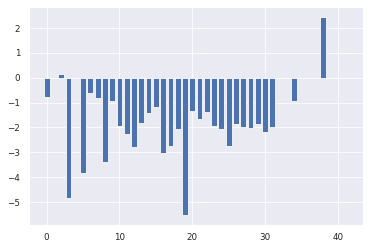

In [63]:
predict(model,print_features=True,all_dataset=False)

In [66]:
# Dump the results into a file that follows the required Kaggle template
eval_data = pd.read_csv("data/evaluation.csv",error_bad_lines=False)

def write_file(title = "LogisticRegression(42_features)_all_dataset"):
    y_pred = model.predict(X_eval)
    with open(title + ".txt", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "NoRetweets"])
        for index, prediction in enumerate(y_pred):
            writer.writerow([str(eval_data['id'].iloc[index]) , str(int(prediction))])

In [67]:
write_file()

In [ ]:
sys.exit()
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Logistic Regression Feature Importance')
plt.show()